In [2]:
%matplotlib inline
import pandas as pd

In [3]:
# 메타 데이터와 학습용 평점 정보 불러오기
metadata = pd.read_csv('metadata.csv')
ratings = pd.read_csv('ratings-train.csv')

In [23]:
metadata.head(1)

itemid             title      genres country  running_min
0   55396  시라노;연애조작단 (2010)  로맨스/멜로/코미디      한국          121

In [25]:
ratings.head(1)

userid  itemid  rating
0  MVdyRkY=   55396       9

In [4]:
# validation용 평점 정보 불러오기
# 데이터가 너무 크기 때문에 20%(frac = 0.2) 크기만 샘플링
# 학습하는 모두가 같은 샘플 데이터를 갖도록 random_state를 같은 값(17)으로 고정
ratings_valid = pd.read_csv('ratings-valid.csv').sample(random_state=17, frac=0.2)

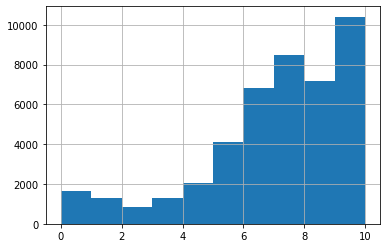

In [5]:
# 평점 정보의 분포 그려보기 (p. 20)
ratings['rating'].hist()

In [6]:
expected = ratings_valid[1:10]
answer = ratings_valid[:10]

In [7]:
# RMSE 계산하는 함수 만들기 (p. 23)
import numpy as np
def rmse(expected, answer):
    joined = pd.merge(answer, expected, on=['userid', 'itemid'], how='left')
    joined['rating_y'] = joined['rating_y'].fillna(0)
    joined['square_error'] = (joined['rating_x'] - joined['rating_y']) ** 2
    return np.sqrt(joined['square_error'].mean())

In [8]:
rmse(expected, answer)

2.8460498941515415

In [9]:
# 모든 예측을 8점으로 하는 추천 로직
def predict(u, i):
    return 8.0

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.7423239390279464

In [10]:
# 모든 예측을 전체 평점의 평균으로 계산하는 추천 로직 (p. 24)
r_mean = ratings['rating'].mean()
def predict(u, i):
    return r_mean

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.418031954051125

In [11]:
# 모든 예측을 주어진 사용자의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict_umean(u, i):
    return ratings[ratings['userid'] == u]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict_umean(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.1909154513519242

In [12]:
# 모든 예측을 주어진 영화의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['itemid'] == i]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.237838086446809

In [13]:
# 서로 다른 사용자 u, v에 대해 jaccard similarity 계산하는 함수 (p. 28)
all_users = ratings['userid'].unique()
i_dict = {u: set(ratings[ratings['userid'] == u]['itemid']) for u in all_users}
def sim(u, v):
    # i_u = set(ratings[ratings['userid'] == u]['itemid'])
    # i_v = set(ratings[ratings['userid'] == v]['itemid'])
    i_u = i_dict[u]
    i_v = i_dict[v]
    
    cup = i_u | i_v
    if len(cup) == 0:
        return 0.0
    cap = i_u & i_v
    return len(cap) / len(cup)

In [14]:
sim('TERhUA==', 'Q1ladXM=')

0.08333333333333333

In [15]:
# 비슷한 영화를 소비한 k명의 사용자 집합 U_u를 계산하는 similar_users(u, k) 함수 (p. 29)
def similar_users(u, k):
    sims = sorted([(sim(u, v), v) for v in all_users if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

In [16]:
similar_users('TERhUA==', 5)

userid
0  YzkyQQ==
1  NGdmcVQ=
2  M2hETGQ=
3  V0NyaQ==
4  QTB5d0E=

In [17]:
def predict(u, i):
    topk_users = similar_users(u, 5)
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    i_ratings = ratings[ratings['itemid'] == i]
    joined = pd.merge(topk_users, i_ratings, on='userid')
    joined['weighted_rating'] = joined['sim'] * joined['rating']
    return joined['weighted_rating'].sum() / joined['sim'].sum()

In [18]:
expected = ratings_valid.copy()
expected['rating'] = expected.apply(lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


4.4360709881776135

In [19]:
ratings.sample()

userid  itemid  rating
38062  QnJBZXY=   53513       6

In [38]:
#    top_k 유저를 i 영화를 본 적이 있는 사람 중에 고른다.
#    sum{(u와 v의 sim)(v의 i평점 - v의 전체 평점 평균)}
#         ----------  -------      ---------------
#    ----      1        2               3
#      4
#    u의 전체 영화 평균 => 5

# 비슷한 영화를 소비한 k명의 사용자 집합 U_u를 계산하는 similar_users(u, k) 함수 (p. 29)


# ----- 보민님 코드 ---

# def predict_bonus(u, i):
#     r_bar = predict_u_mean(u)
#     topk_users = similar_users(u, 5)
#     topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
#     topk_users_with_rating = topk_users.merge(ratings_valid, how='left', on='userid')
#     topk_users_with_rating['mean'] = topk_users_with_rating.apply(lambda row: predict_u_mean(row['userid']), axis=1)
#     topk_users_with_i_rating = topk_users_with_rating[topk_users_with_rating['itemid'] == i]
    
#     topk_users_with_i_rating['weighted'] = topk_users_with_i_rating['sim']*(topk_users_with_i_rating['rating']-topk_users_with_i_rating['mean'])
    
#     return r_bar if topk_users_with_i_rating['sim'].sum() == 0 else r_bar + topk_users_with_i_rating['weighted'].sum() / topk_users_with_i_rating['sim'].sum()
# Collapse

#---

def predict_umean(u, i):
    return ratings[ratings['userid'] == u]['rating'].mean()

def similar_users(u, k, a):
    sims = sorted([(sim(u, v), v) for v in a if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

def predict(u, i):  
    a = ratings[ratings['itemid'] == i]['userid'].unique()
    topk_users = similar_users(u, 5, a)
        # 1 (u와 v의 sim)
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    
    # 3 (v의 전체 평점 평균)
    
    topk_users['mean_rate'] = topk_users.apply(lambda row: predict_umean(row['userid'], 0), axis=1)
    
    # 2 (i영화의 유저마다 평점)
    i_ratings = ratings[ratings['itemid'] == i]
    
    joined = pd.merge(topk_users, i_ratings, on='userid')
    
    joined['weighted_rating'] = joined['sim'] * (joined['rating'] - joined['mean_rate'])
   
    # 4 
    sum_j = joined['weighted_rating'].sum() / joined['sim'].sum()
    
    # 5
    r_u_mean = predict_umean(u, 2)
    
    return r_u_mean + sum_j

In [39]:
expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.131802386637612